# Sentiment Analysis using LSTM and GRU

### Project by : Deepthi D'Souza

The aim of the project appears to be sentiment analysis on airline tweets. The code is designed to train deep learning models (specifically LSTM and GRU) to classify the sentiment expressed in tweets about airlines into three categories: negative, neutral, and positive.

### Dataset Information

* The dataset contains tweets with associated sentiment labels regarding various airlines.
* Each tweet is labeled with one of the sentiments: 'negative', 'neutral', or 'positive'.
* The aim of this project is to train machine learning models to predict the sentiment of airline tweets.


### Step 1: Importing required libraries

In [25]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [ ]:
# Checking for available device (GPU/CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Step 2: Loading Dataset

In [26]:
# Importing and displaying datatset
df = pd.read_csv('Tweets.csv')
display(df)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14635,569587686496825344,positive,0.3487,NaN,0.0000,American,NaN,KristenReenders,NaN,0,@AmericanAir thank you we got on a different f...,NaN,2015-02-22 12:01:01 -0800,NaN,NaN
14636,569587371693355008,negative,1.0000,Customer Service Issue,1.0000,American,NaN,itsropes,NaN,0,@AmericanAir leaving over 20 minutes Late Flig...,NaN,2015-02-22 11:59:46 -0800,Texas,NaN
14637,569587242672398336,neutral,1.0000,NaN,NaN,American,NaN,sanyabun,NaN,0,@AmericanAir Please bring American Airlines to...,NaN,2015-02-22 11:59:15 -0800,"Nigeria,lagos",NaN
14638,569587188687634433,negative,1.0000,Customer Service Issue,0.6659,American,NaN,SraJackson,NaN,0,"@AmericanAir you have my money, you change my ...",NaN,2015-02-22 11:59:02 -0800,New Jersey,Eastern Time (US & Canada)


In [27]:
# Extracting column names
column_names = df.columns
print(column_names)

Index(['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline',
       'airline_sentiment_gold', 'name', 'negativereason_gold',
       'retweet_count', 'text', 'tweet_coord', 'tweet_created',
       'tweet_location', 'user_timezone'],
      dtype='object')


### Step 3: Data Visualization

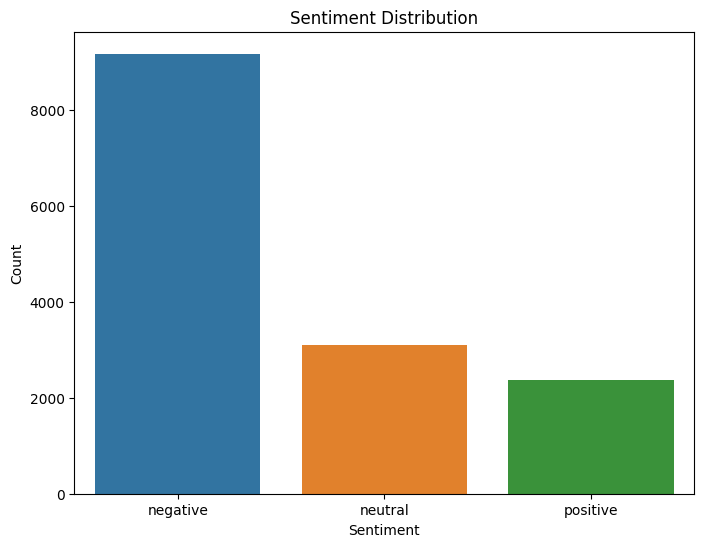

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting the distribution of sentiments
plt.figure(figsize=(8,6))
sns.countplot(x='airline_sentiment', data=df, order=['negative', 'neutral', 'positive'])
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()


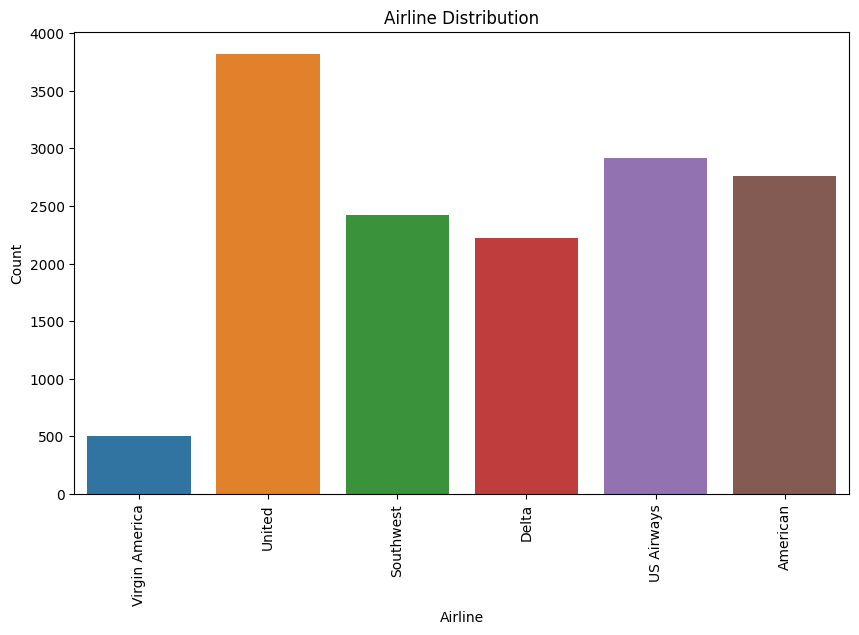

In [29]:
# Plotting the distribution of airlines
plt.figure(figsize=(10,6))
sns.countplot(x='airline', data=df)
plt.title('Airline Distribution')
plt.xlabel('Airline')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()


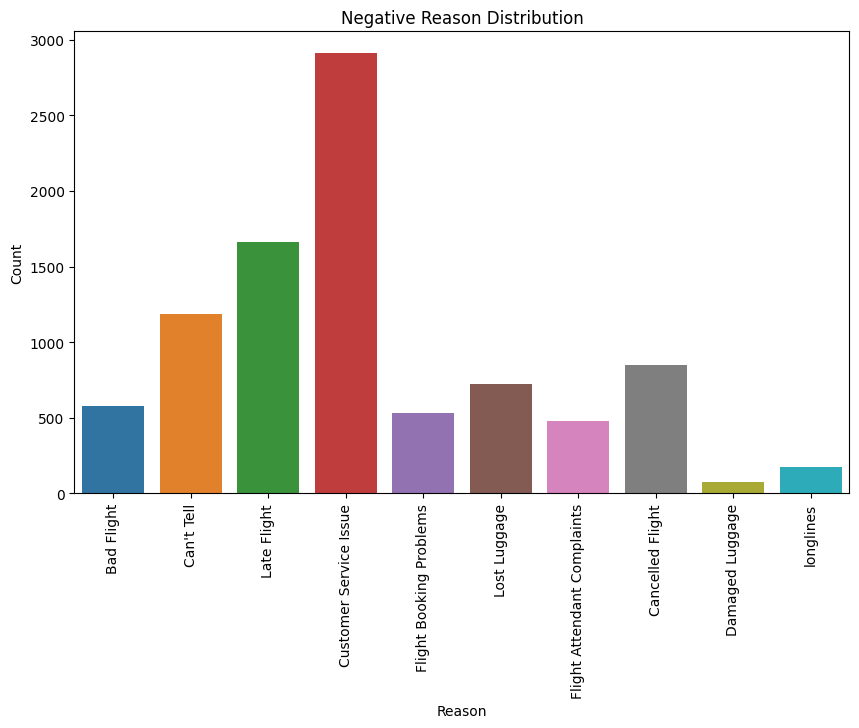

In [30]:
# Plotting the distribution of negative reasons for negative sentiment tweets
plt.figure(figsize=(10,6))
sns.countplot(x='negativereason', data=df[df['airline_sentiment']=='negative'])
plt.title('Negative Reason Distribution')
plt.xlabel('Reason')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()


### Step 4: Data pre-processing

In [31]:
# Selecting relevant columns and dropping missing values
df = df[['airline_sentiment', 'text']]
df.dropna(inplace=True)

# Printing main statistics of the dataset
print("Main Statistics:")
print("Number of tweets:", len(df))
print("Number of unique sentiments:", df['airline_sentiment'].nunique())
print("Sentiment distribution:")
print(df['airline_sentiment'].value_counts())


Main Statistics:
Number of tweets: 14640
Number of unique sentiments: 3
Sentiment distribution:
negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64


<ipython-input-31-cc03d1767b76>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)


In [11]:
# Preparing data for model training:
# Extracting features and labels
X = df['text'].values
y = df['airline_sentiment'].values

# Encoding labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Tokenizing and padding text sequences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
X = tokenizer.texts_to_sequences(X)

max_sequence_length = 100
X = pad_sequences(X, maxlen=max_sequence_length)

# Splitting data into train, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

### Step 5: Model Building : **LSTM**

In [ ]:
class SentimentLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(SentimentLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=3, batch_first=True)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)
        output, _ = self.lstm(embedded)
        output = self.dropout(output[:, -1, :])
        output = self.fc(output)
        return output

### Step 6: Model training - 6 Setups with 3 varying hyperparameters

Epoch 1/3, Train Loss: 0.7982209899523153, Val Loss: 0.6836517457221005
Epoch 2/3, Train Loss: 0.5650182792554537, Val Loss: 0.6378745215164648
Epoch 3/3, Train Loss: 0.4030840268212374, Val Loss: 0.6490329475821676


Epoch 1/4, Train Loss: 0.8334623083874986, Val Loss: 0.785827658678356
Epoch 2/4, Train Loss: 0.6817796230316162, Val Loss: 0.6865650854612652
Epoch 3/4, Train Loss: 0.565162074324247, Val Loss: 0.6464903731095163
Epoch 4/4, Train Loss: 0.47741911298519857, Val Loss: 0.6385930823652368


Epoch 1/5, Train Loss: 0.7642924256699077, Val Loss: 0.6773923937533353
Epoch 2/5, Train Loss: 0.5746125639400385, Val Loss: 0.6297385140850738
Epoch 3/5, Train Loss: 0.4586096921166462, Val Loss: 0.6390546177690094
Epoch 4/5, Train Loss: 0.353195230530594, Val Loss: 0.6631237820193574
Epoch 5/5, Train Loss: 0.25142766471710626, Val Loss: 0.7434788591958381


Epoch 1/5, Train Loss: 0.7648096688269755, Val Loss: 0.6458392619681196
Epoch 2/5, Train Loss: 0.5479268537192215, Val Loss: 0.6620

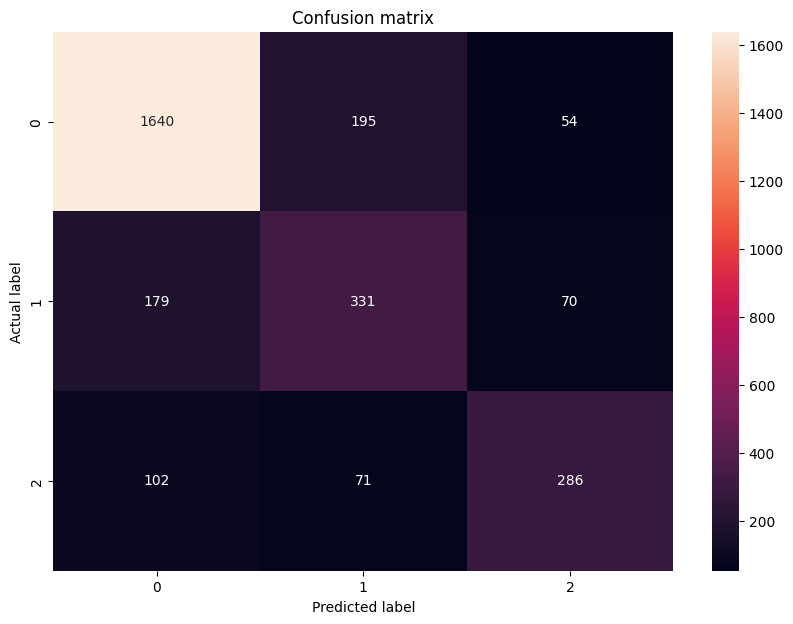

In [19]:
# Defining different setups with varying hyperparameters
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 100
hidden_dim = 128
output_dim = len(label_encoder.classes_)

setups = [
    {'batch_size': 32, 'learning_rate': 0.01, 'num_epochs': 3},
    {'batch_size': 128, 'learning_rate': 0.001, 'num_epochs': 4},
    {'batch_size': 32, 'learning_rate': 0.001, 'num_epochs': 5},
    {'batch_size': 16, 'learning_rate': 0.01, 'num_epochs': 5},
    {'batch_size': 32, 'learning_rate': 0.001, 'num_epochs': 4},
    {'batch_size': 64, 'learning_rate': 0.01, 'num_epochs': 4}
]

best_val_loss = float('inf')
best_setup = None

# Looping over different setups
for setup in setups:
    batch_size = setup['batch_size']
    learning_rate = setup['learning_rate']
    num_epochs = setup['num_epochs']

    # Initializing model, criterion, and optimizer
    model = SentimentLSTM(vocab_size, embedding_dim, hidden_dim, output_dim).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Converting data to PyTorch tensors and creating data loaders
    X_train_tensor = torch.LongTensor(X_train).to(device)
    y_train_tensor = torch.LongTensor(y_train).to(device)
    X_val_tensor = torch.LongTensor(X_val).to(device)
    y_val_tensor = torch.LongTensor(y_val).to(device)

    train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataset = torch.utils.data.TensorDataset(X_val_tensor, y_val_tensor)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Training the model
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0

        for batch_x, batch_y in train_loader:
            optimizer.zero_grad()
            output = model(batch_x)
            loss = criterion(output, batch_y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        model.eval()
        val_loss = 0.0

        with torch.no_grad():
            for batch_x, batch_y in val_loader:
                output = model(batch_x)
                loss = criterion(output, batch_y)
                val_loss += loss.item()

        print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss / len(train_loader)}, Val Loss: {val_loss / len(val_loader)}")

    # Saving the best model based on validation loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_setup = setup

        torch.save(model.state_dict(), 'best_model_lstm.pt')

    print("")
    print("")

print('Best setup:')
print(best_setup)

model = SentimentLSTM(vocab_size, embedding_dim, hidden_dim, output_dim).to(device)
model.load_state_dict(torch.load('best_model_lstm.pt'))

X_test_tensor = torch.LongTensor(X_test).to(device)
y_test_tensor = torch.LongTensor(y_test).to(device)

test_dataset = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

actual_labels = []
predicted_labels = []

model.eval()
test_loss = 0.0
correct = 0


with torch.no_grad():
    for batch_x, batch_y in test_loader:
        output = model(batch_x)
        loss = criterion(output, batch_y)
        test_loss += loss.item()
        _, predicted = torch.max(output, 1)
        correct += (predicted == batch_y).sum().item()

        actual_labels.extend(batch_y.detach().cpu().numpy())
        predicted_labels.extend(predicted.detach().cpu().numpy())

test_loss /= len(test_loader)
accuracy = correct / len(X_test)

print(f"Test Loss: {test_loss}, Accuracy: {accuracy}")

cm = confusion_matrix(actual_labels, predicted_labels)

import seaborn as sns
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()


### Step 7: Model Building : **Gated Recurrent Unit**

In [ ]:
class SentimentGRU(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(SentimentGRU, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.gru = nn.GRU(embedding_dim, hidden_dim, num_layers=3, batch_first=True)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)
        output, _ = self.gru(embedded)
        output = self.dropout(output[:, -1, :])
        output = self.fc(output)
        return output

### Step 8: Model training - 6 Setups with 3 varying hyperparameters

Epoch 1/3, Train Loss: 0.7586320915319814, Val Loss: 0.6577026014392441
Epoch 2/3, Train Loss: 0.5631619422814138, Val Loss: 0.6536339541544786
Epoch 3/3, Train Loss: 0.4754917698915501, Val Loss: 0.6907438506951203


Epoch 1/4, Train Loss: 0.756953190986802, Val Loss: 0.6787082858987756
Epoch 2/4, Train Loss: 0.5752724177983343, Val Loss: 0.6153283521935746
Epoch 3/4, Train Loss: 0.4769648066183337, Val Loss: 0.5936820700361922
Epoch 4/4, Train Loss: 0.3765143137805316, Val Loss: 0.6573949134027636


Epoch 1/5, Train Loss: 0.8468182691128181, Val Loss: 0.8013336948446326
Epoch 2/5, Train Loss: 0.7318875718442246, Val Loss: 0.7462325084048349
Epoch 3/5, Train Loss: 0.6743610153426083, Val Loss: 0.7025092739511181
Epoch 4/5, Train Loss: 0.622459090610413, Val Loss: 0.6805273640800167
Epoch 5/5, Train Loss: 0.5769484896505245, Val Loss: 0.6583687510039355


Epoch 1/5, Train Loss: 0.7911591146128576, Val Loss: 0.7113970565755351
Epoch 2/5, Train Loss: 0.6459420866908271, Val Loss: 0.72015

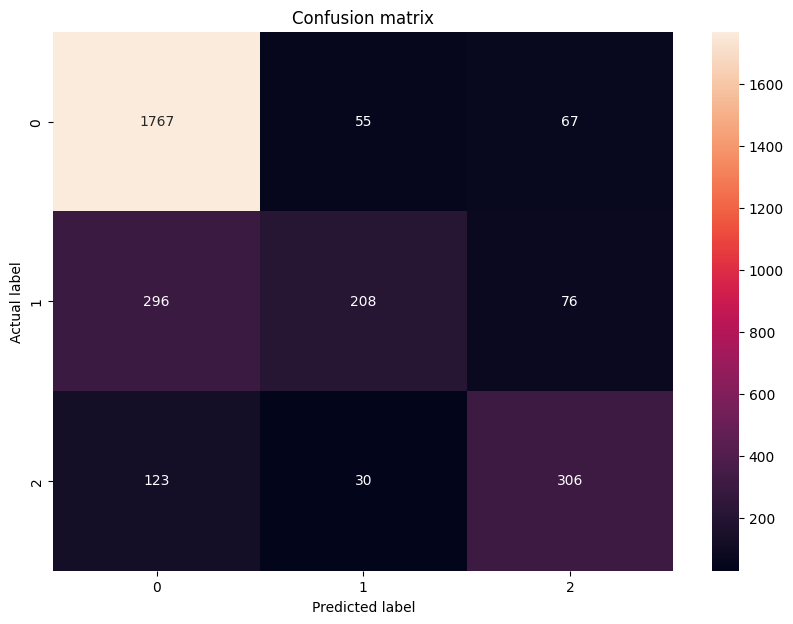

In [18]:

vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 100
hidden_dim = 128
output_dim = len(label_encoder.classes_)

setups = [
    {'batch_size': 32, 'learning_rate': 0.01, 'num_epochs': 3},
    {'batch_size': 64, 'learning_rate': 0.001, 'num_epochs': 4},
    {'batch_size': 32, 'learning_rate': 0.0001, 'num_epochs': 5},
    {'batch_size': 16, 'learning_rate': 0.01, 'num_epochs': 5},
    {'batch_size': 32, 'learning_rate': 0.001, 'num_epochs': 4},
    {'batch_size': 32, 'learning_rate': 0.01, 'num_epochs': 4}
]

best_val_loss = float('inf')
best_setup = None

for setup in setups:
    batch_size = setup['batch_size']
    learning_rate = setup['learning_rate']
    num_epochs = setup['num_epochs']

    model = SentimentGRU(vocab_size, embedding_dim, hidden_dim, output_dim).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    X_train_tensor = torch.LongTensor(X_train).to(device)
    y_train_tensor = torch.LongTensor(y_train).to(device)
    X_val_tensor = torch.LongTensor(X_val).to(device)
    y_val_tensor = torch.LongTensor(y_val).to(device)

    train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataset = torch.utils.data.TensorDataset(X_val_tensor, y_val_tensor)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0

        for batch_x, batch_y in train_loader:
            optimizer.zero_grad()
            output = model(batch_x)
            loss = criterion(output, batch_y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        model.eval()
        val_loss = 0.0

        with torch.no_grad():
            for batch_x, batch_y in val_loader:
                output = model(batch_x)
                loss = criterion(output, batch_y)
                val_loss += loss.item()

        print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss / len(train_loader)}, Val Loss: {val_loss / len(val_loader)}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_setup = setup

        torch.save(model.state_dict(), 'best_model_GRU.pt')

    print("")
    print("")

print('Best setup:')
print(best_setup)

model = SentimentGRU(vocab_size, embedding_dim, hidden_dim, output_dim).to(device)
model.load_state_dict(torch.load('best_model_GRU.pt'))

X_test_tensor = torch.LongTensor(X_test).to(device)
y_test_tensor = torch.LongTensor(y_test).to(device)

test_dataset = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

actual_labels = []
predicted_labels = []

model.eval()
test_loss = 0.0
correct = 0


with torch.no_grad():
    for batch_x, batch_y in test_loader:
        output = model(batch_x)
        loss = criterion(output, batch_y)
        test_loss += loss.item()
        _, predicted = torch.max(output, 1)
        correct += (predicted == batch_y).sum().item()

        actual_labels.extend(batch_y.detach().cpu().numpy())
        predicted_labels.extend(predicted.detach().cpu().numpy())

test_loss /= len(test_loader)
accuracy = correct / len(X_test)

print(f"Test Loss: {test_loss}, Accuracy: {accuracy}")

print("")

cm = confusion_matrix(actual_labels, predicted_labels)

import seaborn as sns
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()